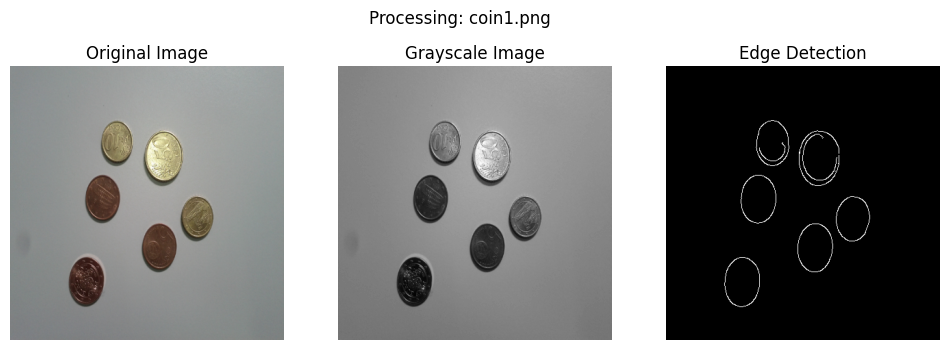

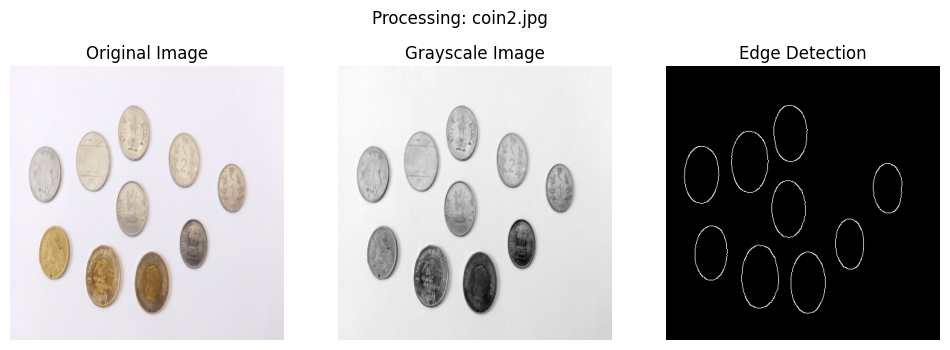

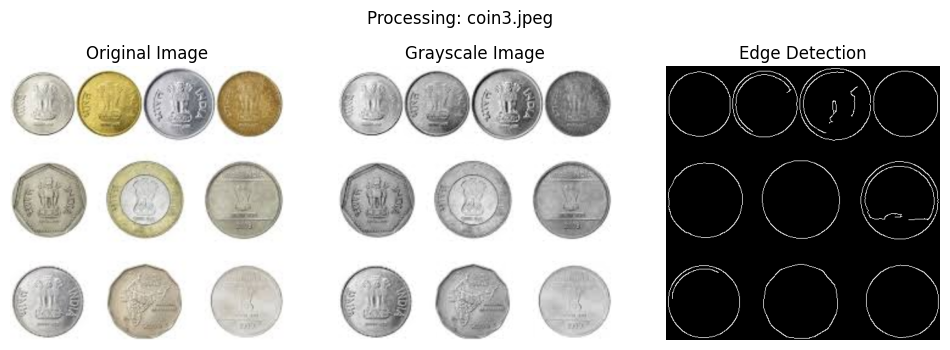

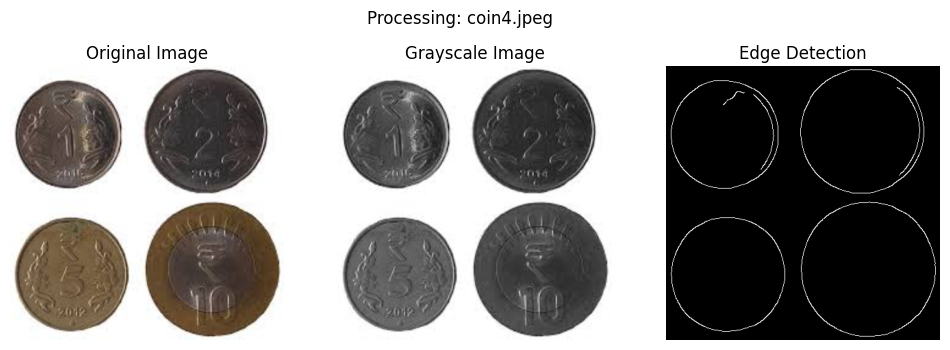

Edge-detected images saved in: ./Edges


In [10]:
import cv2
import os
import matplotlib.pyplot as plt

# Define input and output folders
input_folder = "./input_coins"
output_folder = "./Edges"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get a list of all image files in the folder
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# List to store results
processed_images = []

# Process each image
for image_file in image_files:
    image_path = os.path.join(input_folder, image_file)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Unable to load {image_file}")
        continue  # Skip this image if it cannot be loaded

    # Resize the image
    image = cv2.resize(image, (400, 400))

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(gray, (11, 11), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blur, 30, 140)

    # Store the results in an array (dictionary for each image)
    processed_images.append({
        "filename": image_file,
        "original": cv2.cvtColor(image, cv2.COLOR_BGR2RGB),  # Convert to RGB for proper matplotlib display
        "gray": gray,
        "edges": edges
    })

    # Save the edge-detected image in "Edges" folder with "_edge" in the filename
    edge_filename = f"{os.path.splitext(image_file)[0]}_edge.jpg"
    edge_path = os.path.join(output_folder, edge_filename)
    cv2.imwrite(edge_path, edges)

# Display results
for img_data in processed_images:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Processing: {img_data['filename']}")
    
    axes[0].imshow(img_data["original"])
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(img_data["gray"], cmap="gray")
    axes[1].set_title("Grayscale Image")
    axes[1].axis("off")
    
    axes[2].imshow(img_data["edges"], cmap="gray")
    axes[2].set_title("Edge Detection")
    axes[2].axis("off")
    
    plt.show()

print(f"Edge-detected images saved in: {output_folder}")


In [11]:
def extract_circular_objects(img, edge_map):
    # Enhance the edges using dilation
    processed_edges = cv2.dilate(edge_map, kernel=(1, 1), iterations=2)

    # Find contours from the processed edges
    found_contours, _ = cv2.findContours(processed_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours to retain only circular shapes
    circular_contours = [
        contour for contour in found_contours
        if len(cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)) > 5
    ]

    return circular_contours


In [17]:
def coinSegmentation(image, contours, image_name, output_folder="./segments"):
    """ Extract, display, and save each segmented coin from contours. """

    # Create a directory for each image inside "segments/"
    image_segment_folder = os.path.join(output_folder, image_name)
    os.makedirs(image_segment_folder, exist_ok=True)

    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        coin_segment = image[y:y+h, x:x+w]

        # Save each segmented coin
        segment_path = os.path.join(image_segment_folder, f"coin_{i+1}.jpg")
        cv2.imwrite(segment_path, coin_segment)

        # Display segmented coin
        # print(f"Segmented Coin {i+1} from {image_name}:")
        # cv2_imshow(coin_segment)

In [18]:
def coinsCount(contours):
    return len(contours)

In [19]:
import os
import cv2

contours_folder = "./contours"
os.makedirs(contours_folder, exist_ok=True)

for img_data in processed_images:
    image_name = os.path.splitext(img_data["filename"])[0]  # Remove extension
    image = img_data["original"]
    edges = img_data["edges"]

    # Detect contours
    contours = extract_circular_objects(image, edges)

    # Count and print number of coins
    num_coins = coinsCount(contours)
    print(f"Number of coins in {img_data['filename']}: {num_coins}")

    contoured_image = image.copy()
    cv2.drawContours(contoured_image, contours, -1, (0, 255, 0), 2)

    # Save the contoured image with correct filename
    contoured_filename = f"{image_name}_contour.jpg"
    contoured_path = os.path.join(contours_folder, contoured_filename)
    cv2.imwrite(contoured_path, contoured_image)

    # Segment and save coins
    coinSegmentation(image, contours, image_name)

print(f"Segmented coins saved in: {contours_folder}")


Number of coins in coin1.png: 6
Number of coins in coin2.jpg: 9
Number of coins in coin3.jpeg: 10
Number of coins in coin4.jpeg: 4
Segmented coins saved in: ./contours
